<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Notebook-to-test-Walk-Forward-Optimisation-'with-memory'" data-toc-modified-id="Notebook-to-test-Walk-Forward-Optimisation-'with-memory'-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Notebook to test Walk Forward Optimisation 'with memory'</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Data</a></span></li></ul></li><li><span><a href="#WF-optimization-with-memory---2000:2020" data-toc-modified-id="WF-optimization-with-memory---2000:2020-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>WF optimization with memory - 2000:2020</a></span></li><li><span><a href="#Check-last-robust_ir,-weights-and-cummulated_weights" data-toc-modified-id="Check-last-robust_ir,-weights-and-cummulated_weights-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Check last robust_ir, weights and cummulated_weights</a></span><ul class="toc-item"><li><span><a href="#Heatmaps-with-widgets" data-toc-modified-id="Heatmaps-with-widgets-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Heatmaps with widgets</a></span></li></ul></li><li><span><a href="#See-OOS-performance" data-toc-modified-id="See-OOS-performance-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>See OOS performance</a></span></li></ul></li></ul></div>

# Notebook to test Walk Forward Optimisation 'with memory'

The purpose of this notebook is to test the selection of the best MA combination based on a new logic. This new functionality, written in the function get_best_combination_new() is based on the idea of assigning weights in every In Sample and adding them in every IS period with the previous ones. This way, the new selection of parameters is not only based on the last IS period, but also on the previous ones.  
The logic is the following one:  
- cummulative_weights = [0,0...]
- For each IS period:
    - calculate IR from each parameter combination.  
    - calculate robust_IR based on the IR of each parameter combination and its neighbors. Robust_IR = (Individual_IR + neighbors_average_IR) / 2.
    - weights = Robust_IR / sum(Robust_IR) . 
        - Note: we exclude negative IRs in this sum, and include market_ir. Excluding negative IRs can influence negatively the weights in a single IS in case of a smaller amount of combinations with positive IR. This boosts the cummulative_weights of parameters combination that are positive when most are negative. Show example of IS=2000:2002, OOS=2003
    - cummulative_weights += weights
    - best_combination = max(cummulative_weights)
    - OOS with best_combination

The intention behing this idea is to select parameters that are more stable in the long term. Parameters that are more often among the best ones (in term of IR) will be selected more often. This additive weights will also be slower at adapting to new market conditions. But we aim to select a combination that has a good performance in most periods. Instead of trying to pick the best combination for each OOS period.  
This should provide the strategy with a lower volatility (because we try selecting the one which is more often among the best ones).  
This can also be seen (similarly) in Simpson´s paradox:

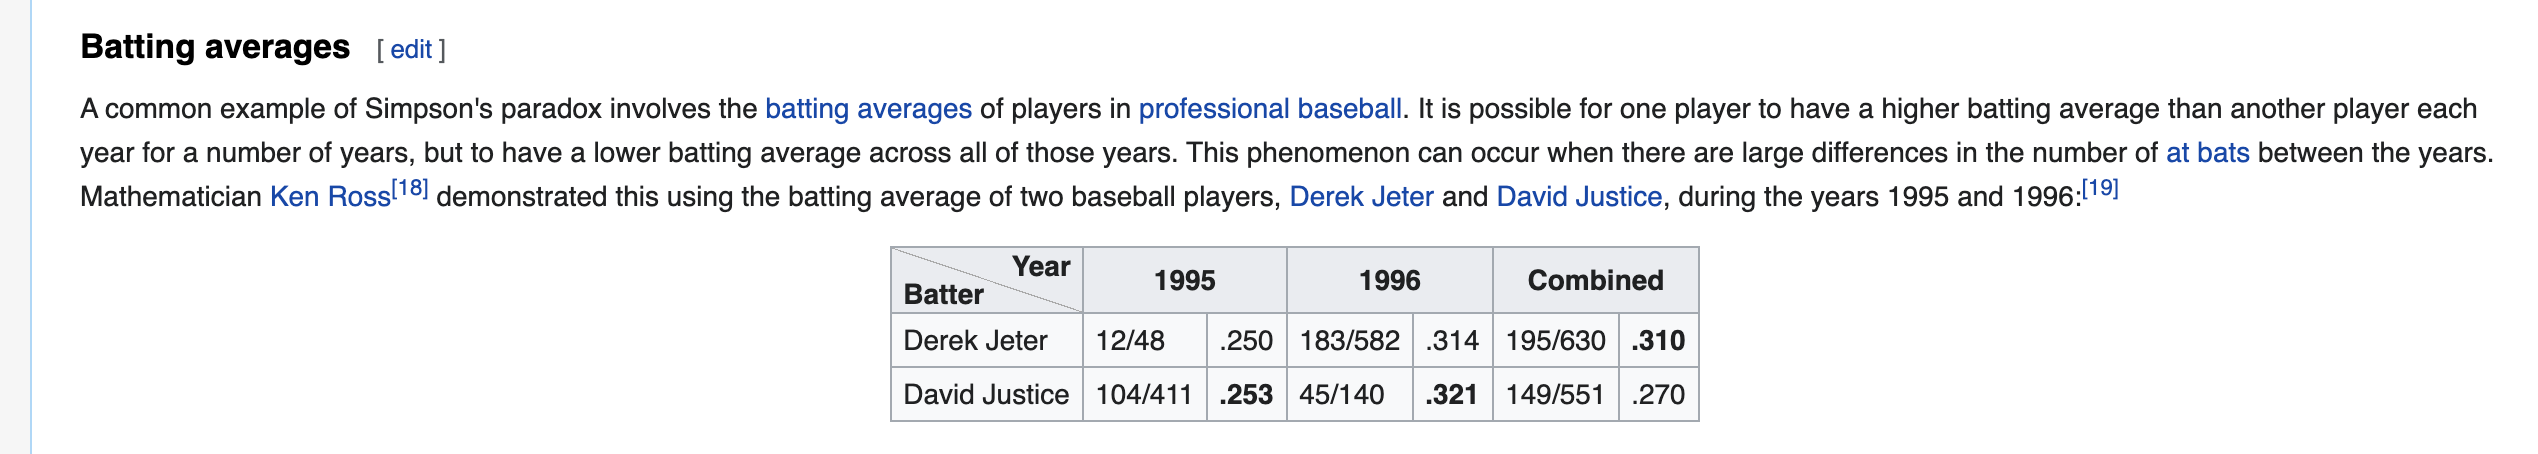

In [1]:
from IPython.display import Image
Image(filename='/Users/Sergio/Documents/Master_QF/Thesis/Presentations/Research WF with weights/SimpsonsParadox.png')

This may seem confusing, but is important to understand the type of returns that we want, and what we dont want.  
A type of strategy similar to 'Black Swan' hedge funds, in which we have low returns for most of the time, but exceptional return in short periods of time is not desirable. Even if the final return is positive.    
We would prefer to have stable (with low volatility) and better than average, consistently. That is why we want to have some kind of memory in the selection of parameters of the model.  

<b>Conclusions after this analysis: </b>
- Initially, this logic could seem similar to one in which the beggining of the IS period is hooked to the first IS period (IS period windows would be increasing constantly). And it is obvious that results of the optimizations will be similar at some point. But the new logic seems to be choosing more robust parameters which lead to a lower volatility. (See Batting averages from Simpsons Paradox. The new logic would be equivalent to David Justice, which the 'hooked' IS period would be equivalent to Derek Jeter). <b>Show plots 2a and 2b: </b>
    - 2.a Parameter optimization from 1980 to 2020. Some parameters seem better than buy&hold.
    - 2.b cummulated weights from 1980 to 2019. None of them was as consistent year-by-year as buy&hold.
    
- Difference between previous and new logic of choosing parameters:
    - <b>Show plots 4c and 4d: </b> (This needs a deeper analysis)

- The new logic seems to deliver stable results (low drawdowns and volatility, except for 2020 because of the very sharp falls):
    - <b>Show plots C </b> (This needs a deeper analysis like calculating performance metrics)

- The start of the IS period is important for the selection of parameters. The market from the initial IS periods will assign high weights to some parameters, which may not be desirable. A possible solution would be to increase the size of the first IS period, so the model has a larger sample to learn from and choose the first parameter combinations.
    - <b>Plot 1c and heatmaps from section "WF optimization with memory - 1970:2020" </b>. 
    - Parameters (1,5) perform extremely good for the first 10 years (20% of the sample), and they are chosen forever. 


<b>Solutions: </b>
- Add limit of memory to the model. For now, we will try a limit of 10 IS periods for the cummulative weights.
- Add maximum weight added per IS window. This will stop certain parameters to have a lot of weight added in a window in which there were very few positive strategies.

### Imports

In [2]:
# Settings for notebook visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline
from IPython.core.display import HTML
HTML("""<style>.output_png img {display: block;margin-left: auto;margin-right: auto;text-align: center;vertical-align: middle;} </style>""")

In [3]:
# Necessary imports
import os
import numpy as np
import pandas as pd
import matplotlib as plt
from tqdm.auto import tqdm, trange
print("Libraries imported correctly")

Libraries imported correctly


In [4]:
os.chdir("/Users/Sergio/Documents/Master_QF/Thesis/Code/Algorithmic Strategies")
%run Functions.ipynb

### Data

In [5]:
ini_equity_default = 100
commision_default = 2/130000 + 12.5/130000 #0.000111538462, around 0.011..% of the equity

Close  Market_daily_ret
Date                                     
2020-12-02  3669.010010          0.001791
2020-12-03  3666.719971         -0.000624
2020-12-04  3699.120117          0.008836
2020-12-07  3691.959961         -0.001936
2020-12-08  3702.250000          0.002787

<AxesSubplot:title={'center':'SP500'}, xlabel='Date'>

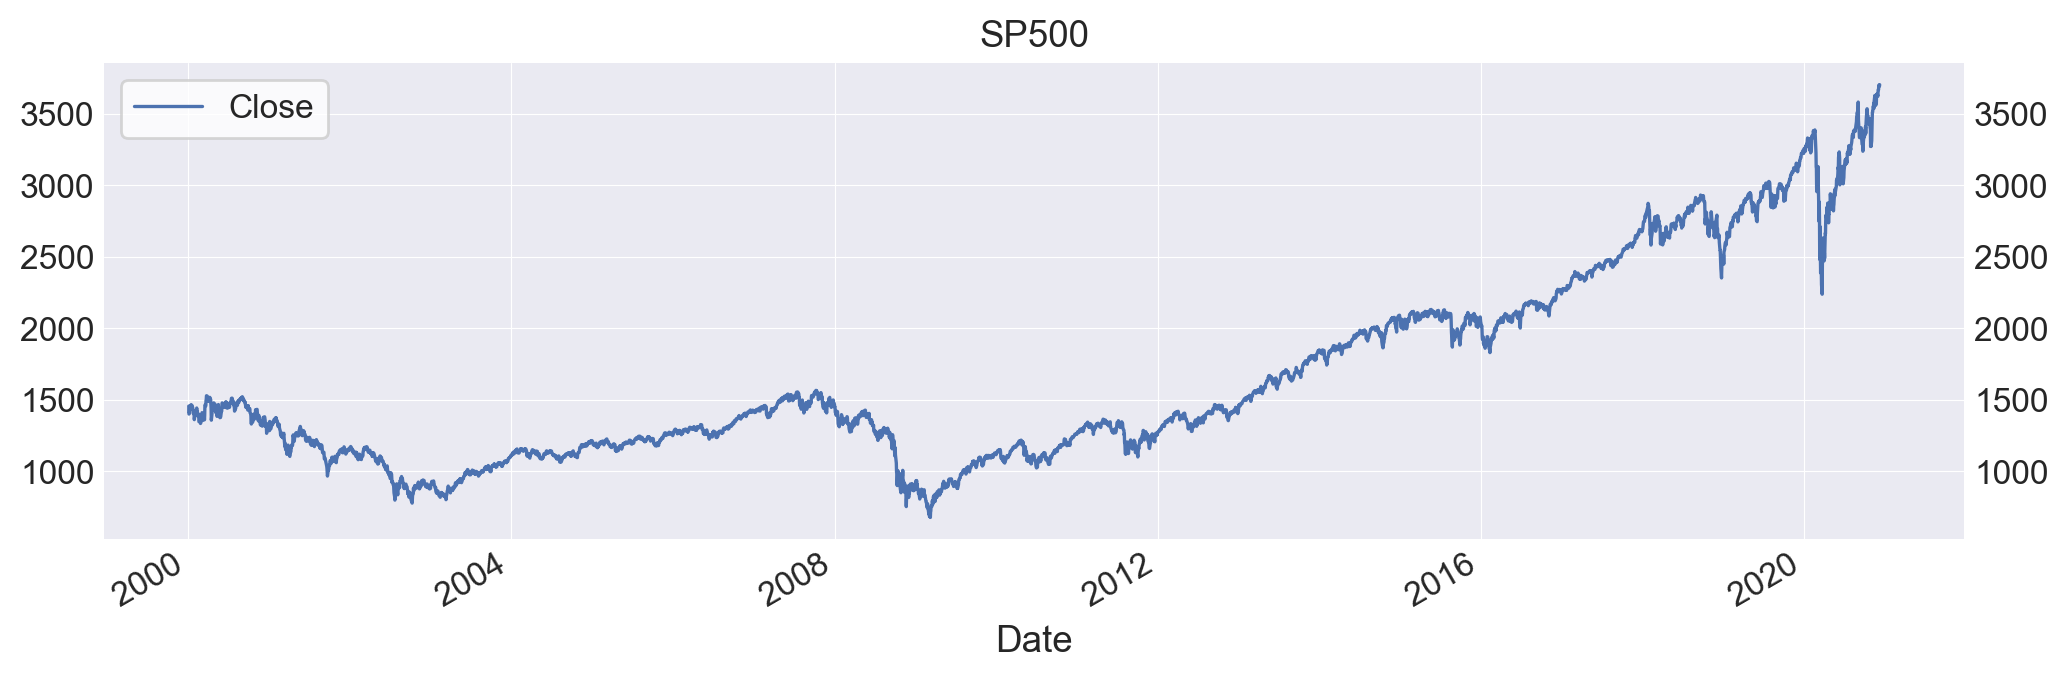

In [6]:
%run Functions.ipynb

#data = get_sp500_data(from_local_file=False, save_to_file=True)
data = get_sp500_data(from_local_file=True, save_to_file=False)
data = data[['Open', 'Close']]

data['Market_daily_ret'] = data['Close'].pct_change().fillna((data['Close']-data['Open'])/data['Open'])
data = data.loc['2000':'2020' ,['Close', 'Market_daily_ret']]

data.tail()
data['Close'].plot(title='SP500', legend=True)

## WF optimization with memory - 2000:2020

In [7]:
%run Functions.ipynb

memory_len = 10

fast_ma_list = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 500, 500]
slow_ma_list = [5, 10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300]

IS_start = pd.date_range(start='2000-01-01', end='2017-01-01', freq='1YS', closed=None)
IS_end = pd.date_range(start='2002-12-31', end='2019-12-31', freq='1Y', closed=None)
OOS_start = pd.date_range(start='2003-01-01', end='2020-01-01', freq='1YS', closed=None)
OOS_end = pd.date_range(start='2003-12-31', end='2020-12-31', freq='1Y', closed=None)

print(f'Number of combinations: {len(fast_ma_list)*len(slow_ma_list)}\n' 
      f'Length of memory (# of IS periods): {memory_len}')
print_periods(IS_start, IS_end, OOS_start, OOS_end)

num_combinations = len(fast_ma_list)*len(slow_ma_list)
num_is_years = round((IS_end[0]-IS_start[0]).days/365, 0)
num_oos_years = round((OOS_end[0]-OOS_start[0]).days/365, 0)
info_wf_str = (f'Running {num_combinations} backtests on \n'
               f'\t{len(IS_start)} IS rolling windows of {num_is_years} years\n'
               f'\t{len(OOS_start)} OOS rolling windows of {num_oos_years} years\n'
               f'->Total of {num_combinations*len(IS_start)+len(OOS_start)*2} backtests'
               f'\tMemory of {memory_len} IS periods\n'
              )
        

num_neighbors_matrix = get_num_neighbors(fast_ma_list, slow_ma_list)

Number of combinations: 289
Length of memory (# of IS periods): 10
Number of periods: 18 : 18     18 : 18
	In SAMPLE		OOS
2000-01-01 : 2002-12-31 	 2003-01-01 : 2003-12-31
2001-01-01 : 2003-12-31 	 2004-01-01 : 2004-12-31
2002-01-01 : 2004-12-31 	 2005-01-01 : 2005-12-31
... ... ... ... ... ... 	 ... ... ... ... ... ...
2016-01-01 : 2018-12-31 	 2019-01-01 : 2019-12-31
2017-01-01 : 2019-12-31 	 2020-01-01 : 2020-12-31


In [8]:
%run Functions.ipynb
hide = True

df_wf_2000 = data[IS_start[0]:OOS_end[-1]].copy()
#df_walk_forward = df_walk_forward.loc[:'2020-05-02']

if hide == True:
    # Copy data and create necessary columns 
    new_cols = ['Strat_daily_ret', 'Strat_position', 'Long_only', 'Costs', 'Market_cum_ret']

    df_wf_2000= df_wf_2000.reindex(columns = df_wf_2000.columns.tolist() + new_cols)

    last_position = 0 # We suppose that we start not being invested. 1:long, -1:short

    optimization_results_list_2000 = []
    robust_optimization_results_list_2000 = []
    market_ir_list_2000 = []

    weights_list_2000 = []
    weights_list_2000.append(np.zeros((len(fast_ma_list),len(slow_ma_list))))

    cummulative_weights_2000 = []

    fast_ma_best_list_2000 = []
    slow_ma_best_list_2000 = []

    print(info_wf_str)
    
for i in trange(len(IS_start), desc='Walk Forward loop:'):    
    print(f'{IS_start[i].year} to {IS_end[i].year}')
    strats_ir_matrix = np.zeros((len(fast_ma_list),len(slow_ma_list)))
    strat_pnl_matrix = np.zeros((len(fast_ma_list),len(slow_ma_list)))
    weights = np.zeros((len(fast_ma_list),len(slow_ma_list)))
    
    is_period = df_wf_2000.loc[IS_start[i]:IS_end[i]].copy()
    oos_period = df_wf_2000.loc[OOS_start[i]:OOS_end[i]].copy()
    
    ############################################ IN SAMPLE  ############################################
    strat_pnl_matrix, strats_ir_matrix, market_pnl, market_ir = run_all_combinations(is_period, fast_ma_list, slow_ma_list, last_position)
    optimization_results_list_2000.append(strats_ir_matrix)
    market_ir_list_2000.append(market_ir)
    
    # Get index of maximum IR for the In-Sample period, or buy_and_hold if it performed better
    fast_index, slow_index, robust_strats_ir_matrix, weights = get_best_combination_with_memory(strats_ir_matrix, 
                                                                            weights_list_2000[-(memory_len-1):].copy(), # i.e. last (10-1) cummulative weights. 1 more will be added inside
                                                                              market_ir, num_neighbors_matrix)
    robust_optimization_results_list_2000.append(robust_strats_ir_matrix)
    weights_list_2000.append(weights)
    cummulative_weights_2000.append(np.sum(weights_list_2000[-memory_len:], axis=0))
    
    print("\tBest strategy cummulative weight: {:.3f} Market: {:.3f}".format(cummulative_weights_2000[-1][fast_index, slow_index], cummulative_weights_2000[-1][-1,0]))
    if cummulative_weights_2000[-1][fast_index, slow_index] > cummulative_weights_2000[-1][-1,0]: #b&h ir
        fast_ma_best = fast_ma_list[fast_index]
        slow_ma_best = slow_ma_list[slow_index]
    else: # If buy_and_hold performed better, we select buy_and_hold for the OOS        
        fast_ma_best = 0
        slow_ma_best = 0
    print("\tParams: {} {}" .format(fast_ma_best, slow_ma_best))
    fast_ma_best_list_2000.append(fast_ma_best)
    slow_ma_best_list_2000.append(slow_ma_best)
    
    #print("Best In-sample performance: ")
    if hide == True:
#         print_backtest_stats(is_period, strat_pnl_matrix[fast_index, slow_index], strats_ir_matrix[fast_index, slow_index],
#                              market_pnl, market_ir,
#                              strat_params=(fast_ma_best, slow_ma_best))

#         show_both_heatmaps(strats_ir_matrix, robust_strats_ir_matrix, market_ir, plot_title=str(IS_start.year)+":"+str(IS_end.year), x_title="Slow MA", x_values=slow_ma_list, y_title="Fast MA", y_values=fast_ma_list)    
#         show_both_heatmaps_new(robust_strats_ir_matrix, weights, market_ir, plot_title=str(IS_start.year)+":"+str(IS_end.year), 
#                            x_title="Slow MA", x_values=slow_ma_list, y_title="Fast MA", y_values=fast_ma_list)
#         plt.show()
        hide = True

    ############################################ OUT OF SAMPLE  ############################################
    print("OOS performance:")
    if hide == True:
        strategy = ma_crossover(oos_period, fast_ma_best, slow_ma_best)
        oos_period, last_position, strat_pnl, strat_ir, market_pnl, market_ir = backtest_strat(oos_period, strategy, previous_position=last_position)
        print_backtest_stats(oos_period, strat_pnl, strat_ir, market_pnl, market_ir, strat_params=(fast_ma_best, slow_ma_best))

        # Save come columns from OOS
        df_wf_2000.loc[OOS_start[i]:OOS_end[i], new_cols] = oos_period[new_cols]

    print()
    
# Delete first element from weights_list_2000 (it was initialized to 0)
weights_list_2000 = weights_list_2000[1:]

print("End of Walk Forward Optimization")

Running 289 backtests on 
	18 IS rolling windows of 3.0 years
	18 OOS rolling windows of 1.0 years
->Total of 5238 backtests	Memory of 10 IS periods



2000 to 2002
	Best strategy cummulative weight: 0.000 Market: 0.000
	Params: 0 0
OOS performance:
Strategy: buy_and_hold()
Period: 2003-01-02 to 2003-12-31
	Overall return of SP500: +26.38 %. IR of SP500: 1.55
	Overall return of strategy: +26.38 %. IR strategy: 1.55

2001 to 2003
	Best strategy cummulative weight: 0.010 Market: 0.000
	Params: 55 220
OOS performance:
Strategy: ma_crossover(55-220)
Period: 2004-01-02 to 2004-12-31
	Overall return of SP500: +8.99 %. IR of SP500: 0.81
	Overall return of strategy: +3.37 %. IR strategy: 0.34

2002 to 2004
	Best strategy cummulative weight: 0.019 Market: 0.001
	Params: 50 240
OOS performance:
Strategy: ma_crossover(50-240)
Period: 2005-01-03 to 2005-12-30
	Overall return of SP500: +3.00 %. IR of SP500: 0.29
	Overall return of strategy: +3.00 %. IR strategy: 0.29

2003 to 2005
	Best strategy cummulative weight: 0.026 Market: 0.008
	Params: 50 240
OOS performance:
Strategy: ma_crossover(50-240)
Period: 2006-01-03 to 2006-12-29
	Overall return o

In [9]:
params_combinations = pd.DataFrame([fast_ma_best_list_2000, slow_ma_best_list_2000], index=['fast_ma', 'slow_ma'], columns=OOS_start.year)
params_combinations

2003  2004  2005  2006  2007  2008  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020
fast_ma     0    55    50    50    50    50    40    40    40    40    40    35    50    50    50    50    40    45
slow_ma     0   220   240   240   240   240   260   260   260   260   260   300   140   140   140   140   140   120

## Check last robust_ir, weights and cummulated_weights

In [10]:
show_both_heatmaps_new(robust_optimization_results_list_2000[-1], weights_list_2000[-1], market_ir_list_2000[-1], 
                       plot_title=f'{str(IS_start[-1].year)}-{str(IS_end[-1].year)}', 
                       left_plot_title="Robust IR", right_plot_title="weights",
                       x_title="Slow MA", x_values=slow_ma_list, y_title="Fast MA", y_values=fast_ma_list) 

In [11]:
show_both_heatmaps_new(weights_list_2000[-1], cummulative_weights_2000[-1], market_ir_list_2000[-1], 
                       plot_title=f'{str(IS_start[-1].year)}-{str(IS_end[-1].year)}',
                       left_plot_title="weights", right_plot_title="Cummulative weights",
                       x_title="Slow MA", x_values=slow_ma_list, y_title="Fast MA", y_values=fast_ma_list)

### Heatmaps with widgets

In [12]:
%run Functions.ipynb
from ipywidgets import widgets

options = [year for year in IS_start.year]

selection_slider = widgets.SelectionSlider(
    options=options,
    description='Starting IS year',
    orientation='horizontal',
    layout={'width': '900px'},
)
#selection_slider

def plot_heatmap(year):
    index = year - IS_start.year[0]
    show_both_heatmaps_new(robust_optimization_results_list_2000[index], weights_list_2000[index], market_ir_list_2000[index], 
                           plot_title=str(year), left_plot_title="Robust IR", right_plot_title="weights",
                           x_title="Slow MA", x_values=slow_ma_list, y_title="Fast MA", y_values=fast_ma_list)   

widgets.interact(
    plot_heatmap,
    year=selection_slider
);

interactive(children=(SelectionSlider(description='Starting IS year', layout=Layout(width='900px'), options=(2…

In [13]:
%run Functions.ipynb
from ipywidgets import widgets

options = [year for year in IS_start.year]

selection_slider = widgets.SelectionSlider(
    options=options,
    description='Starting IS year',
    orientation='horizontal',
    layout={'width': '900px'},
)
#selection_slider

def plot_heatmap(year):
    index = year - IS_start.year[0]
    #show_both_heatmaps(optimization_results_list[index], robust_optimization_results_list[index], market_ir_list[index], plot_title=str(year), x_title="Slow MA", x_values=slow_ma_list, y_title="Fast MA", y_values=fast_ma_list)    
    show_both_heatmaps_new(weights_list_2000[index], cummulative_weights_2000[index], market_ir_list_2000[index], 
                           plot_title=str(year), left_plot_title="weights", right_plot_title="Cummulative weights",
                           x_title="Slow MA", x_values=slow_ma_list, y_title="Fast MA", y_values=fast_ma_list)   
    
widgets.interact(
    plot_heatmap,
    year=selection_slider
);

interactive(children=(SelectionSlider(description='Starting IS year', layout=Layout(width='900px'), options=(2…

## See OOS performance

Initial invested capital = 100.00


AbsRet     ARC      IR      aSD       MD      AMD     MLD  All Risk   ARCMD  ARCAMD  Num Trades  Out of market
MA Crossover with WF memory  185.9305  6.0376  0.4472  13.5024  33.5949  10.2225  2.2122    1.0258  0.1797  0.5906          21            952
Buy and Hold                 320.7963  8.3488  0.4329  19.2839  56.7754  14.7927  5.4648    8.8506  0.1471  0.5644           1              0

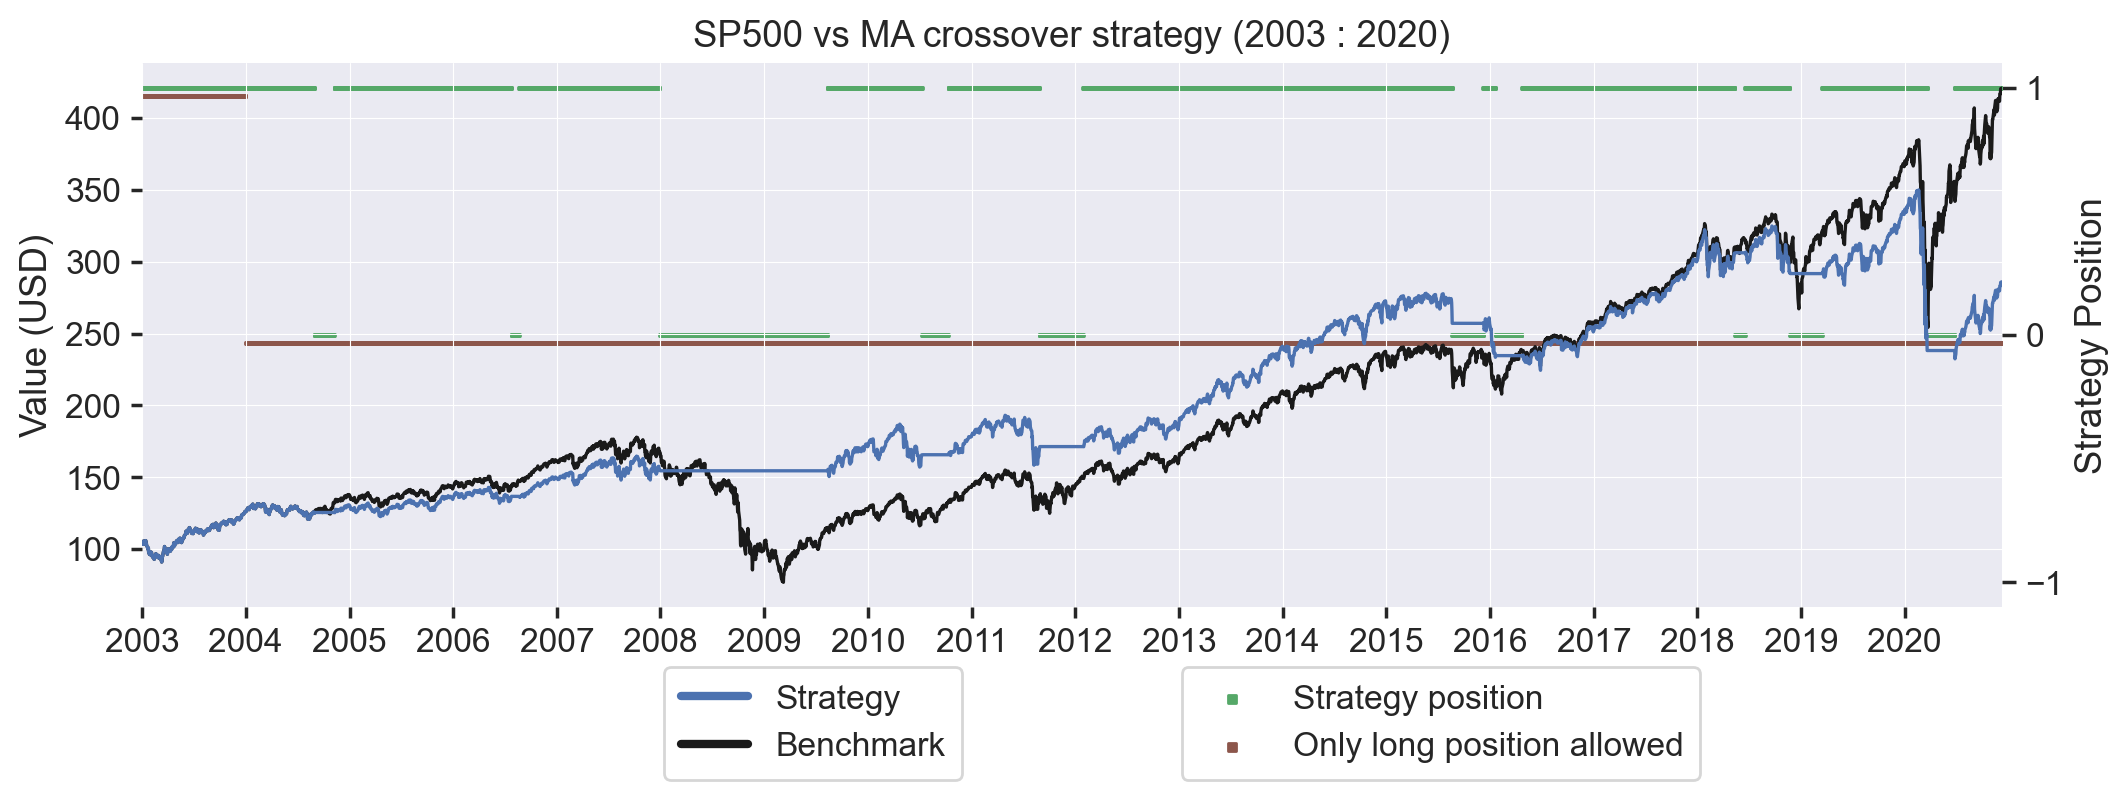

In [14]:
%run Functions.ipynb
#ini_mon = df_wf_1970[str(OOS_start[0].year-1)].iloc[-1]['Close']
ini_mon = 100
print("Initial invested capital = {:.2f}".format(ini_mon))

results_df = prepare_oos_df(df_wf_2000.loc[OOS_start[0]:OOS_end[-1]].copy(), ini_equity=ini_mon)
#results_df = prepare_oos_df(df_wf_1970.loc['2000':].copy(), ini_equity=ini_mon)

metrics = calculate_performance_metrics(results_df, strat_name='MA Crossover with WF memory')
metrics

show_oos_plot(results_df, with_legend=True)